<a href="https://colab.research.google.com/github/agamduggal/Topsis-for-Pre-Trained-Models/blob/main/summarization_topsis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import time
import numpy as np
import pandas as pd
import torch
from transformers import pipeline
!pip install datasets
from datasets import load_dataset
!pip install rouge_score
from rouge_score import rouge_scorer
from sklearn.preprocessing import MinMaxScaler

# Load test data (CNN/DailyMail dataset)
dataset = load_dataset("cnn_dailymail", "3.0.0", split="test[:5%]")  # Using 5% of test data
sample_texts = [dataset[i]['article'] for i in range(5)]  # 5 samples for quick evaluation



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [4]:
# List of models to compare
models = ["facebook/bart-large-cnn", "t5-small", "google/pegasus-xsum"]

In [5]:

results = []

for model_name in models:
    summarizer = pipeline("summarization", model=model_name, device=0 if torch.cuda.is_available() else -1)
    total_time = 0
    all_rouge_scores = []

    for text in sample_texts:

        max_input_length = 1024
        text = text[:max_input_length]

        start_time = time.time()
        try:
            summary = summarizer(text, max_length=150, min_length=50, do_sample=False)[0]['summary_text']
        except IndexError:
            print(f"IndexError encountered for model: {model_name}, skipping this sample...")
            continue

        end_time = time.time()
        total_time += (end_time - start_time)

        # Compute ROUGE scores
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        scores = scorer.score(text, summary)
        rouge1, rouge2, rougeL = scores['rouge1'].fmeasure, scores['rouge2'].fmeasure, scores['rougeL'].fmeasure
        all_rouge_scores.append((rouge1, rouge2, rougeL))

    # Average ROUGE scores
    avg_rouge1 = np.mean([r[0] for r in all_rouge_scores])
    avg_rouge2 = np.mean([r[1] for r in all_rouge_scores])
    avg_rougeL = np.mean([r[2] for r in all_rouge_scores])
    avg_time = total_time / len(sample_texts)

    results.append([model_name, avg_rouge1, avg_rouge2, avg_rougeL, avg_time])

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cuda:0


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Device set to use cuda:0


In [6]:
# Convert results to a DataFrame
df = pd.DataFrame(results, columns=["Model", "ROUGE-1", "ROUGE-2", "ROUGE-L", "Inference Time"])

# Normalize the Data for TOPSIS
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df.iloc[:, 1:])

In [7]:
# Define positive and negative ideal solutions
ideal_best = np.max(normalized_data, axis=0)
ideal_worst = np.min(normalized_data, axis=0)

# Euclidean Distance
distance_best = np.sqrt(((normalized_data - ideal_best) ** 2).sum(axis=1))
distance_worst = np.sqrt(((normalized_data - ideal_worst) ** 2).sum(axis=1))

# TOPSIS score
topsis_score = distance_worst / (distance_best + distance_worst)

# Rank models
df["TOPSIS Score"] = topsis_score
df["Rank"] = df["TOPSIS Score"].rank(ascending=False)


print(df.sort_values(by="Rank"))


df.to_csv("summarization_model_comparison.csv", index=False)

                     Model   ROUGE-1   ROUGE-2   ROUGE-L  Inference Time  \
0  facebook/bart-large-cnn  0.418920  0.377942  0.392420        1.760555   
1                 t5-small  0.379326  0.334882  0.360968        1.048616   
2      google/pegasus-xsum  0.274686  0.161131  0.207987        1.849757   

   TOPSIS Score  Rank  
0      0.945899   1.0  
1      0.560245   2.0  
2      0.366025   3.0  


<Figure size 1000x600 with 0 Axes>

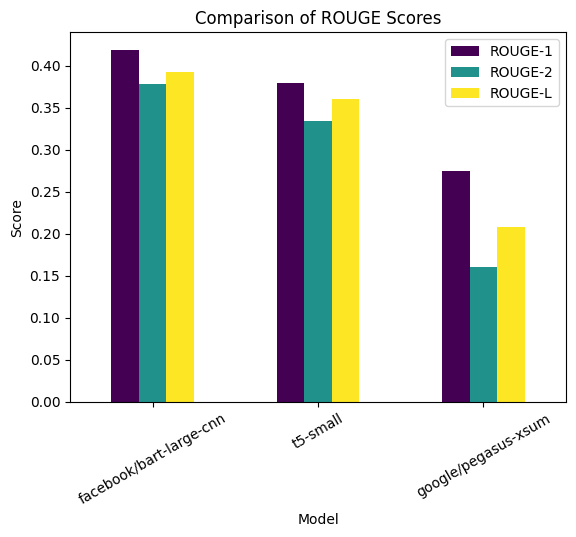

<ipython-input-10-bec35724eb57>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["Model"], y=df["Inference Time"], palette="coolwarm")


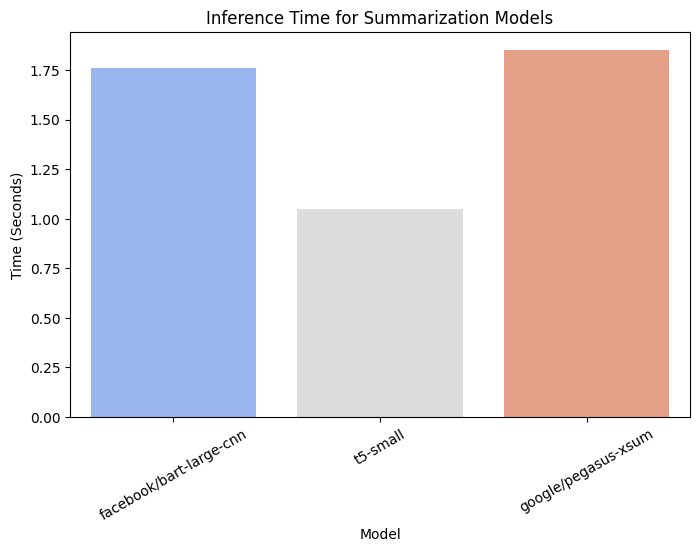

<ipython-input-10-bec35724eb57>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["Model"], y=df["TOPSIS Score"], palette="magma")


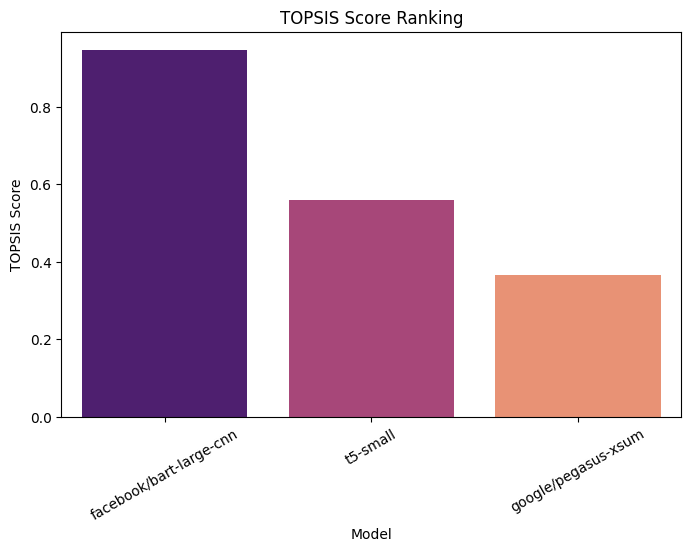

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results
df = pd.read_csv("/content/summarization_model_comparison.csv")

#  Plot ROUGE scores
plt.figure(figsize=(10, 6))
df.set_index("Model")[["ROUGE-1", "ROUGE-2", "ROUGE-L"]].plot(kind="bar", colormap="viridis")
plt.title("Comparison of ROUGE Scores")
plt.ylabel("Score")
plt.xticks(rotation=30)
plt.savefig("rouge_scores.png")
plt.show()

#  Plot Inference Time
plt.figure(figsize=(8, 5))
sns.barplot(x=df["Model"], y=df["Inference Time"], palette="coolwarm")
plt.title("Inference Time for Summarization Models")
plt.ylabel("Time (Seconds)")
plt.xticks(rotation=30)
plt.savefig("inference_time.png")
plt.show()

#  Plot TOPSIS Scores
plt.figure(figsize=(8, 5))
sns.barplot(x=df["Model"], y=df["TOPSIS Score"], palette="magma")
plt.title("TOPSIS Score Ranking")
plt.ylabel("TOPSIS Score")
plt.xticks(rotation=30)
plt.savefig("topsis_scores.png")
plt.show()
